**航空公司评论数据**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
#加载数据
data = pd.read_csv('/home/jhr/Documents/data/Tweets.csv')

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
#选取数据中的特定列
data = data[["airline_sentiment", 'text']]

In [5]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [6]:
data.airline_sentiment.unique()#选出所有分类

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
data.airline_sentiment.value_counts()#总结所有种类数量

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
#选取特定行
data_p = data[data.airline_sentiment == 'positive']
data_n = data[data.airline_sentiment == 'negative']

In [9]:
#将两个类别数据进行长度同步
data_n = data_n[:len(data_p)]

In [10]:
len(data_n), len(data_p)

(2363, 2363)

In [11]:
#利用concat方法，将两端数据拼接在一起
data = pd.concat([data_n, data_p])
data.head

<bound method NDFrame.head of       airline_sentiment                                               text
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
5              negative  @VirginAmerica seriously would pay $30 a fligh...
15             negative      @VirginAmerica SFO-PDX schedule is still MIA.
17             negative  @VirginAmerica  I flew from NYC to SFO last we...
...                 ...                                                ...
14623          positive  @AmericanAir Love the new planes for the JFK-L...
14625          positive  @AmericanAir Flight 236 was great. Fantastic c...
14628          positive  Thank you. “@AmericanAir: @jlhalldc Customer R...
14630          positive                        @AmericanAir Thanks! He is.
14635          positive  @AmericanAir thank you we got on a different f...

[4726 rows x 2 columns]>

In [12]:
# 数据随机化
data = data.sample(len(data))
data

,airline_sentiment,text
8048,positive,@JetBlue currently dancing in the terminal. lo...
2372,negative,"@united Luckily, I had my disinfectant wipes a..."
1695,negative,@united is by far THE WORST airline I've ever ...
7541,positive,“@JetBlue: @2littlebirds Beautiful shot.. Than...
1122,negative,@united you're the reason this whole travel ex...
...,...,...
3595,positive,@united I forgot that Intl flights out of LAX ...
1847,negative,@united no. I need you to have more than 2 age...
1923,negative,"@united right as we think we will take off, we..."
995,negative,@united by the time I finally get to Dallas I ...


In [13]:
#对正负评论进行编码
data['review'] = (data.airline_sentiment == 'positive').astype('int')
data

,airline_sentiment,text,review
8048,positive,@JetBlue currently dancing in the terminal. lo...,1
2372,negative,"@united Luckily, I had my disinfectant wipes a...",0
1695,negative,@united is by far THE WORST airline I've ever ...,0
7541,positive,“@JetBlue: @2littlebirds Beautiful shot.. Than...,1
1122,negative,@united you're the reason this whole travel ex...,0
...,...,...,...
3595,positive,@united I forgot that Intl flights out of LAX ...,1
1847,negative,@united no. I need you to have more than 2 age...,0
1923,negative,"@united right as we think we will take off, we...",0
995,negative,@united by the time I finally get to Dallas I ...,0


**tf.keras.layers.Embedding 把文本向量化**

re.compile() 方法用于编译正则表达式，生成一个 Pattern 对象。该对象可以用于匹配和替换字符串

In [14]:
import re
token = re.compile('[A-Za-z]+|[!?,.()]')#提取单个词汇


In [15]:
def reg_text(text):
    new_test = token.findall(text)
    [word.lower() for word in new_test]
    return new_test

In [16]:
data['text'] = data.text.apply(reg_text)

In [17]:
data

,airline_sentiment,text,review
8048,positive,"[JetBlue, currently, dancing, in, the, termina...",1
2372,negative,"[united, Luckily, ,, I, had, my, disinfectant,...",0
1695,negative,"[united, is, by, far, THE, WORST, airline, I, ...",0
7541,positive,"[JetBlue, littlebirds, Beautiful, shot, ., ., ...",1
1122,negative,"[united, you, re, the, reason, this, whole, tr...",0
...,...,...,...
3595,positive,"[united, I, forgot, that, Intl, flights, out, ...",1
1847,negative,"[united, no, ., I, need, you, to, have, more, ...",0
1923,negative,"[united, right, as, we, think, we, will, take,...",0
995,negative,"[united, by, the, time, I, finally, get, to, D...",0


In [18]:
#创建集合(注意集合不可重复，因此重复的数据会被剔除)
#将评论词汇放到集合中，并剔除掉重复的词汇
word_set = set()
for test in data.text:
    for word in test:
        word_set.add(word)

In [19]:
max_word=len(word_set)+1

In [20]:
#创建列表
word_list = list(word_set)

In [21]:
#创建字典
word_index=dict((word, word_list.index(word)+1) for word in word_list)

In [22]:
word_index

{'Fq': 1,
 'Sad': 2,
 'desktop': 3,
 'first': 4,
 'Dos': 5,
 'general': 6,
 'pissed': 7,
 'switching': 8,
 'travelled': 9,
 'Greatest': 10,
 'limit': 11,
 'delinquent': 12,
 'land': 13,
 'hdndl': 14,
 'stink': 15,
 'charlotte': 16,
 'unserved': 17,
 'moment': 18,
 'xx': 19,
 'ticketing': 20,
 'ages': 21,
 'shower': 22,
 'Vr': 23,
 'Economic': 24,
 'five': 25,
 'cking': 26,
 'claim': 27,
 'Emily': 28,
 'kl': 29,
 'catering': 30,
 'sweet': 31,
 'tho': 32,
 'CRY': 33,
 'this': 34,
 'Ritz': 35,
 'owning': 36,
 'nailed': 37,
 'suit': 38,
 'flightaware': 39,
 'evry': 40,
 'perfect': 41,
 'winks': 42,
 'Who': 43,
 'E': 44,
 'painless': 45,
 'admit': 46,
 'hilarious': 47,
 'BE': 48,
 'constructive': 49,
 'HG': 50,
 'aIyC': 51,
 'carryons': 52,
 'listened': 53,
 'member': 54,
 'neverflyvirgin': 55,
 'barrel': 56,
 'dont': 57,
 'pX': 58,
 'sn': 59,
 'Dude': 60,
 'trains': 61,
 'us': 62,
 'bestinclass': 63,
 'standard': 64,
 'unitedlies': 65,
 'Additionally': 66,
 'it': 67,
 'friendly': 68,
 'kis

In [23]:
#将评论中的词汇通过索引值代替
data_ok=data.text.apply(lambda x:[word_index.get(word,0) for word in x])

In [24]:
data_ok

8048    [3782, 7339, 2448, 4411, 6346, 159, 5328, 4751...
2372    [7067, 5384, 7021, 5128, 2296, 5424, 3814, 179...
1695    [7067, 6126, 2455, 8202, 1258, 8516, 1610, 512...
7541    [3782, 8145, 1827, 4009, 5328, 5328, 603, 3189...
1122    [7067, 4754, 4015, 6346, 7731, 34, 914, 298, 7...
                              ...                        
3595    [7067, 5128, 1810, 4608, 4800, 8466, 6143, 114...
1847    [7067, 5498, 5328, 5128, 5097, 4754, 6150, 178...
1923    [7067, 1985, 3356, 2740, 3923, 2740, 3379, 703...
995     [7067, 2455, 6346, 2067, 5128, 2605, 5201, 615...
3839    [7067, 1433, 936, 6150, 85, 737, 3441, 737, 22...
Name: text, Length: 4726, dtype: object

In [25]:
max_len=max(len(x)for x in data_ok)

In [26]:
#统一每条评论的长度
data_ok=tf.keras.preprocessing.sequence.pad_sequences(data_ok.values,maxlen=max_len)

In [27]:
#data_ok是训练数据
data_ok.shape

(4726, 40)

In [28]:
#标签数据
data.review.values

array([1, 0, 0, ..., 0, 0, 1])

Embeding:把文本映射为一个密集向量（每个单词由24字母构成，字母个数有限）

In [29]:
#创建模型
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_word,
                                    50,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))#二分类用sigmoid，多分类用softmax

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            429850    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 459355 (1.75 MB)
Trainable params: 459355 (1.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [32]:
history=model.fit(data_ok,
          data.review.values,
          epochs=10,
          batch_size=128,
          validation_split=0.2#选取20%作为测试数据
         )

Epoch 1/10
30/30 [==============================] - 3s 50ms/step - loss: 0.6398 - acc: 0.6704 - val_loss: 0.5822 - val_acc: 0.7230
Epoch 2/10
30/30 [==============================] - 1s 31ms/step - loss: 0.4106 - acc: 0.8143 - val_loss: 0.2662 - val_acc: 0.9080
Epoch 3/10
30/30 [==============================] - 1s 32ms/step - loss: 0.1538 - acc: 0.9442 - val_loss: 0.1973 - val_acc: 0.9249
Epoch 4/10
30/30 [==============================] - 1s 33ms/step - loss: 0.0804 - acc: 0.9778 - val_loss: 0.2115 - val_acc: 0.9249
Epoch 5/10
30/30 [==============================] - 1s 32ms/step - loss: 0.0468 - acc: 0.9886 - val_loss: 0.2510 - val_acc: 0.9186
Epoch 6/10
30/30 [==============================] - 1s 32ms/step - loss: 0.0306 - acc: 0.9923 - val_loss: 0.2642 - val_acc: 0.9123
Epoch 7/10
30/30 [==============================] - 1s 35ms/step - loss: 0.0433 - acc: 0.9857 - val_loss: 0.2923 - val_acc: 0.9281
Epoch 8/10
30/30 [==============================] - 1s 32ms/step - loss: 0.0237 - a

In [33]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

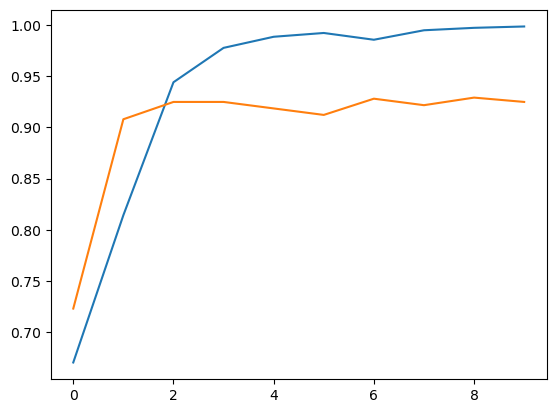

In [34]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')